# Прогнозирование временных рядов

https://www.kaggle.com/datasets/census/population-time-series-data

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

Нужный файл - `POP.csv`. В столбце `value` количество людей в стране в тысячах, колонки `realtime_start` и `realtime_end` относятся к сбору информации и нас не интересуют, а в колонке `date` - месяц, когда были сделаны измерения.

Нас интересует только колонки `date` (запишем ее в индекс) и `value`.

In [310]:
df = pd.read_csv('data/POP.csv', index_col=2, parse_dates=True)
df = df[['value']]
df.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


<AxesSubplot:xlabel='date'>

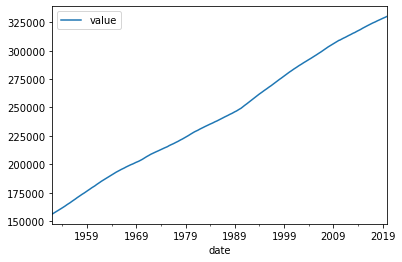

In [311]:
df.plot()

Построим также графики первой и второй разности

<AxesSubplot:xlabel='date'>

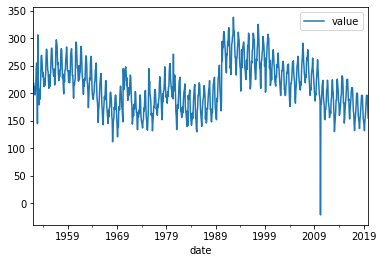

In [312]:
df.diff().plot()

<AxesSubplot:xlabel='date'>

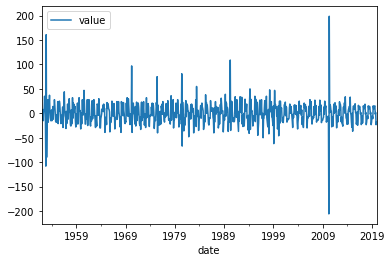

In [313]:
df.diff().diff().plot()

Есть отдельные точки выбросов, но в целом ряд второй разности выглядит стационарным. Попробуем сгладить эти выбросы через скользящую среднюю

<AxesSubplot:xlabel='date'>

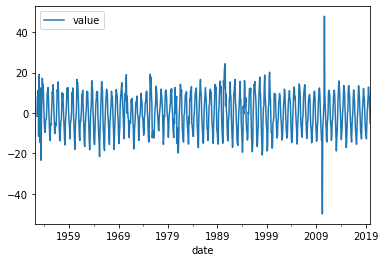

In [314]:
df.diff().diff().dropna().rolling(window=5).mean().plot()

## Проверяем на стационарность

Ряд становится стационарным после двух дифференцирований

In [315]:
statistic, pvalue, *_ = adfuller(df.value)
print(f'Исходный ряд, pvalue={pvalue}')

statistic, pvalue, *_ = adfuller(df.diff().dropna().value)
print(f'Первая разность, pvalue={pvalue}')

statistic, pvalue, *_ = adfuller(df.diff().diff().dropna().value)
print(f'Вторая разность, pvalue={pvalue}')

Исходный ряд, pvalue=0.8555297778919748
Первая разность, pvalue=0.282251227664449
Вторая разность, pvalue=2.1100121875854893e-10


По тесту KPSS ряд становится стацирнарным с уровнем значимости 0.08 (при пороге 0.05) уже после первого дифференцирования.

Для согласованности возьмем вторую разность

In [316]:
statistic, pvalue, *_ = kpss(df.value)
print(f'Исходный ряд, pvalue={pvalue}')

statistic, pvalue, *_ = kpss(df.diff().dropna().value)
print(f'Первая разность, pvalue={pvalue}')

statistic, pvalue, *_ = kpss(df.diff().diff().dropna().value)
print(f'Вторая разность, pvalue={pvalue}')

Исходный ряд, pvalue=0.01
Первая разность, pvalue=0.08032302703968165
Вторая разность, pvalue=0.1


C:\Users\koval\anaconda3\envs\brunoyam-ds-online\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\koval\anaconda3\envs\brunoyam-ds-online\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [317]:
df['second_diff'] = df.diff().diff()
df.head()

,value,second_diff
date,,
1952-01-01,156309.0,NaN
1952-02-01,156527.0,NaN
1952-03-01,156731.0,-14.0
1952-04-01,156943.0,8.0
1952-05-01,157140.0,-15.0


Вопрос для самопроверки - изменится ли результат тестов если перед дифференцированием применить логарифмирование?

## Оценим параметры

In [318]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Оба параметра можно подбирать, начиная с 3. Также есть сезонность с лагом 12.

C:\Users\koval\anaconda3\envs\brunoyam-ds-online\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


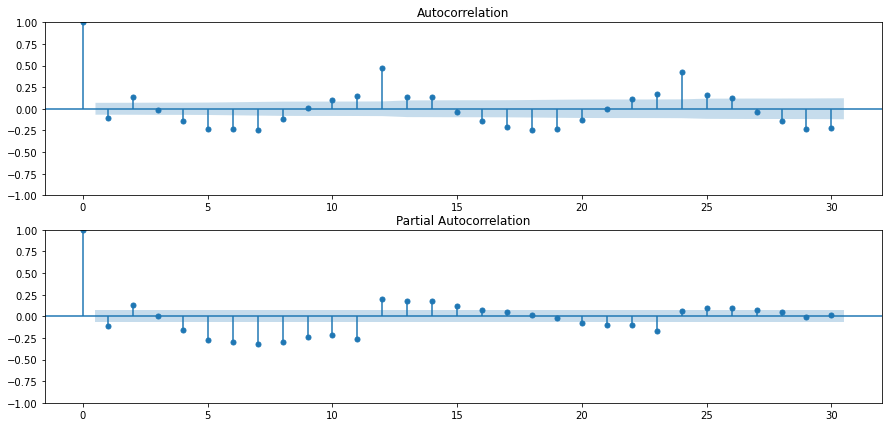

In [319]:
fig, axes = plt.subplots(2, 1)

fig.set_figwidth(15)
fig.set_figheight(7)

plot_acf(df.second_diff.dropna(), ax=axes[0])
plot_pacf(df.second_diff.dropna(), ax=axes[1])
plt.show()

## Разделим на обучающую и тестовую выборку

In [346]:
train, test = train_test_split(df, train_size=0.8, shuffle=False)
train.shape, test.shape

((652, 2), (164, 2))

In [321]:
# pivot_date = '2018-01-01'
# train, test = df.loc[:pivot_date], df.loc[pivot_date:]
# train.shape, test.shape

## Построим модель

In [334]:
model = pmd.auto_arima(train.value, start_p=3, start_q=3, d=2)
model

ARIMA(order=(3, 2, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

На первый взгляд все просто отлично - модель предсказывая на 13 лет вперед ошибается в среднем всего на 2.5 миллиона человек, да и по графику похоже на качественный прогноз

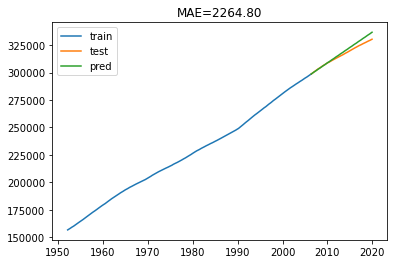

In [335]:
n = len(test)
pred = model.predict(n)

plt.plot(train.value)
plt.plot(test.value)
plt.plot(test.index, pred)
plt.title(f"MAE={mean_absolute_error(test.value, pred):.2f}")
plt.legend(['train', 'test', 'pred'])

Но действительно ли модель так хороша?

## Посмотрим на остатки модели на тренировочной выборке

Выглядит странно... Как будто есть несколько выбросов по бокам, а все остальное распределение нормальное

(array([  1.,   0.,   0., 649.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-78167.97066913, -54678.07360222, -31188.1765353 ,  -7698.27946839,
         15791.61759852,  39281.51466544,  62771.41173235,  86261.30879926,
        109751.20586617, 133241.10293309, 156731.        ]),
 <BarContainer object of 10 artists>)

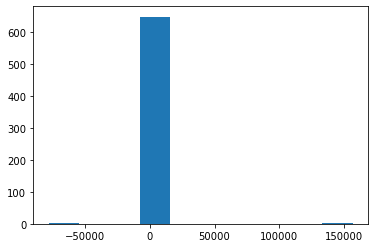

In [336]:
plt.hist(model.resid())

Тест говорит, что распределение ненормальное

In [337]:
shapiro(model.resid())

ShapiroResult(statistic=0.0312809944152832, pvalue=0.0)

Давайте выкинем 1% экстремальных значений с каждой стороны

(array([ 13.,  27.,  56.,  93., 130., 131.,  91.,  62.,  23.,  11.]),
 array([-32.43003525, -25.95463101, -19.47922678, -13.00382254,
         -6.5284183 ,  -0.05301406,   6.42239018,  12.89779442,
         19.37319865,  25.84860289,  32.32400713]),
 <BarContainer object of 10 artists>)

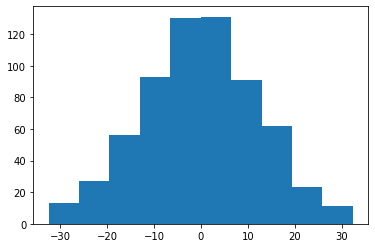

In [338]:
train_resid = model.resid()
lower = np.quantile(train_resid, 0.01)
upper = np.quantile(train_resid, 0.99)
train_resid = train_resid[(lower < train_resid) & (train_resid < upper)]
plt.hist(train_resid)

In [339]:
shapiro(train_resid)

ShapiroResult(statistic=0.9971879720687866, pvalue=0.3458620607852936)

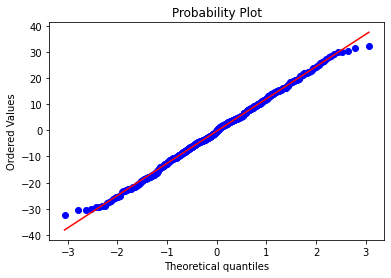

In [340]:
fig, ax = plt.subplots()
stats.probplot(train_resid, plot=ax)
plt.show()

На уровне значимости 0.05 мы не можем отклонить нулевую гипотезу о том, что распределение нормальное, поэтому давайте считать, что на тренировочной выборке остатки распределены нормально, за исключением нескольких выбросов, но вообще-то результат не очень уверенный.

## Посмотрим на остатки модели на тестовой выборке

In [341]:
resid = test.value - pred
shapiro(resid)

ShapiroResult(statistic=0.911116361618042, pvalue=2.1041007158828506e-08)

Тут довольно типичная картинка - чем дальше, тем меньше точность модели. До 2010 года прогноз выглядит более уверенным, давайте рассмотрим его отдельно.

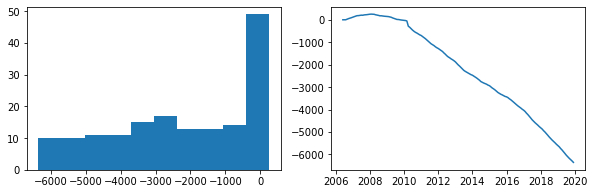

In [342]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(resid)
axes[1].plot(resid)

Распределение все равно далеко от нормального, но в целом ошибка довольно маленькая и видно, что модель не уловила тренд

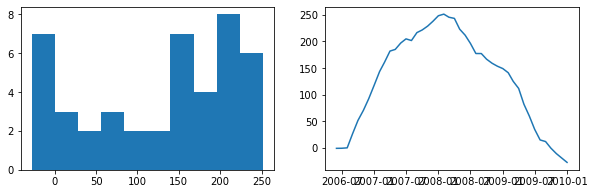

In [343]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(resid.loc[:'2010-01-01'])
axes[1].plot(resid.loc[:'2010-01-01'])

## Построим прогноз в будущее

In [344]:
model = pmd.auto_arima(df.value, start_p=3, start_q=3, d=2)
model

ARIMA(order=(3, 2, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

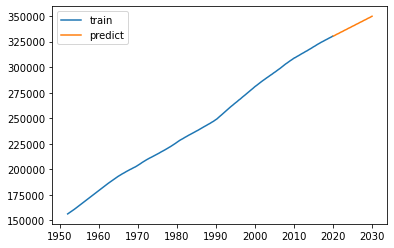

In [345]:
n = 120
plt.plot(df.value)
plt.plot(pd.date_range(df.index[-1], periods=n + 1, freq='M')[1:], model.predict(n))
plt.legend(['train', 'predict'])

Выглядит правдоподобно, но мы держим в голове, что модель не уловила весь тренд в данных и может серьезно ошибаться в некоторых точках